## Загрузка библиотек, чтение данных, определение основных функций

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

free_movements = pd.read_csv('free_movements.csv', index_col=0)

OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
INDEX = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'RUN time'] # для удобства вывода отчетов
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

gestures_train = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol = pd.read_csv('gestures_protocol.csv')

gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

In [5]:
import time
import serial
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error as mse
# for model_1
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor
#for model_2
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing_static(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y, axis=1)

def preprocessing(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference_1(x):
    """_получение предсказаний модели_1
        стек на VotingRegressor из DecisionTreeRegressor и LassoLars_

    """
    return model_vr.predict(x.reshape(1,-1))[0]

def inference_2(x):
    """_получение предсказаний модели_2
        lightgbm через MultiOutputRegressor_

    """
    return model_vr.predict(x.reshape(1,-1))[0]

def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [6]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [7]:
# Fitting model_1 (~13s)

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators))

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model_vr.fit(X, y)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('dt',
                                                            DecisionTreeRegressor()),
                                                           ('ll',
                                                            LassoLars())]))

In [5]:
# Fitting model_2 (~9s)

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


model_lgbm = MultiOutputRegressor(lgb.LGBMRegressor(
                                    learning_rate=0.25,
                                    num_leaves=32,
                                    max_depth=35,
                                    min_data_in_leaf=108
))

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model_lgbm.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108


MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.25, max_depth=35,
                                             min_data_in_leaf=108,
                                             num_leaves=32))

In [8]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


## Дальнейший скрипт может:

* Работать не с первого раза

* Ощутимо так тормозить

* На некоторое время загрузить все 8 ядер моего (дрянного ноутбука от Honor) на 100%

* Крешнуть ядро

### наслаждайтесь)

In [10]:
TIMEOUT = 0.033 #не каждый раз получается за 33 мс
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[], мои попытки сделать буфер для предсказаний
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference_1(sample_preprocessed) # inference_1 - для стека линейки и дерева, inference_2 для градиентного бустинга
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 0. 10.  0. 20. 10.  0.]


In [11]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 100)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


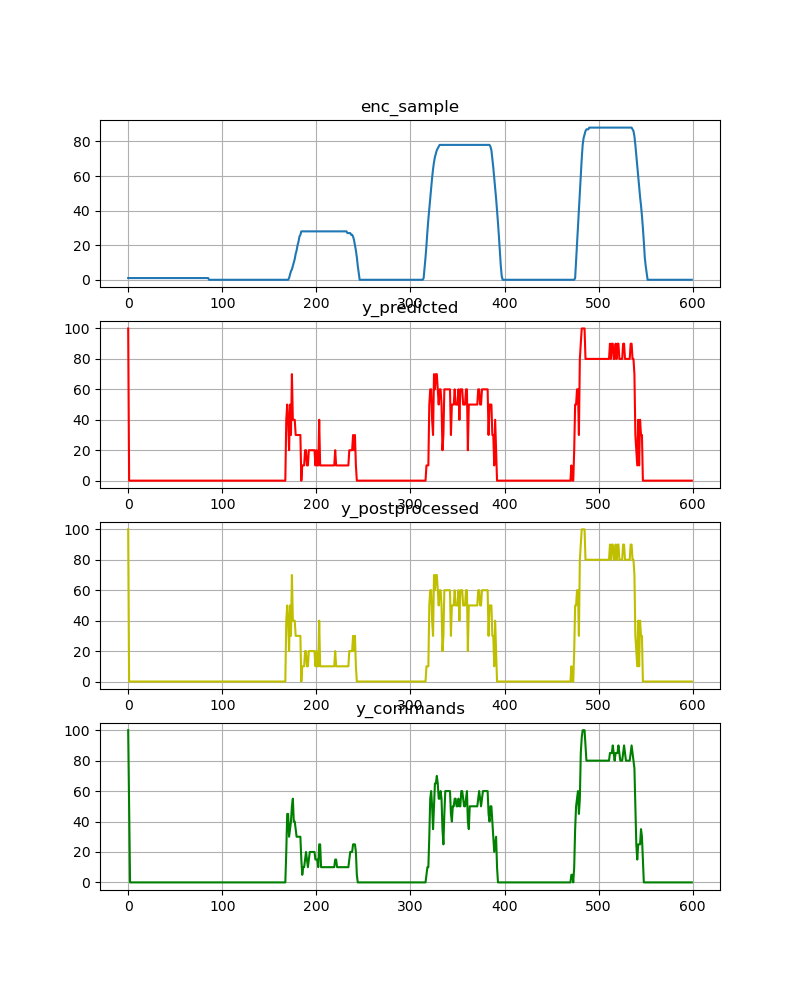

In [13]:
plt.clf()
fig, ax = plt.subplots(4, 1, figsize=(8, 10))

ax[0].set_title('enc_sample')
ax[0].plot(y_dct['enc_sample'][:,3][:600])
ax[0].grid()
ax[1].set_title('y_predicted')
ax[1].plot(y_dct['y_predicted'][:,3][:600], c='r')
ax[1].grid()
ax[2].set_title('y_postprocessed')
ax[2].plot(y_dct['y_postprocessed'][:,3][:600], c='y')
ax[2].grid()
ax[3].set_title('y_commands')
ax[3].plot(y_dct['y_commands'][:,3][:600], c='g')
ax[3].grid()

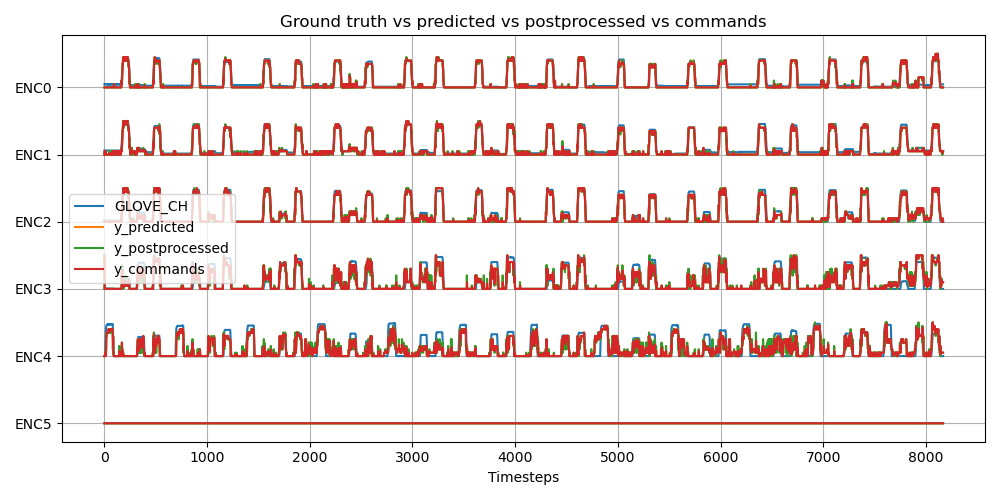

In [14]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

***

Теперь для градиентного бустинга

In [15]:
TIMEOUT = 0.033
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference_2(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 


SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 0. 10.  0. 20. 10.  0.]


In [16]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 100)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


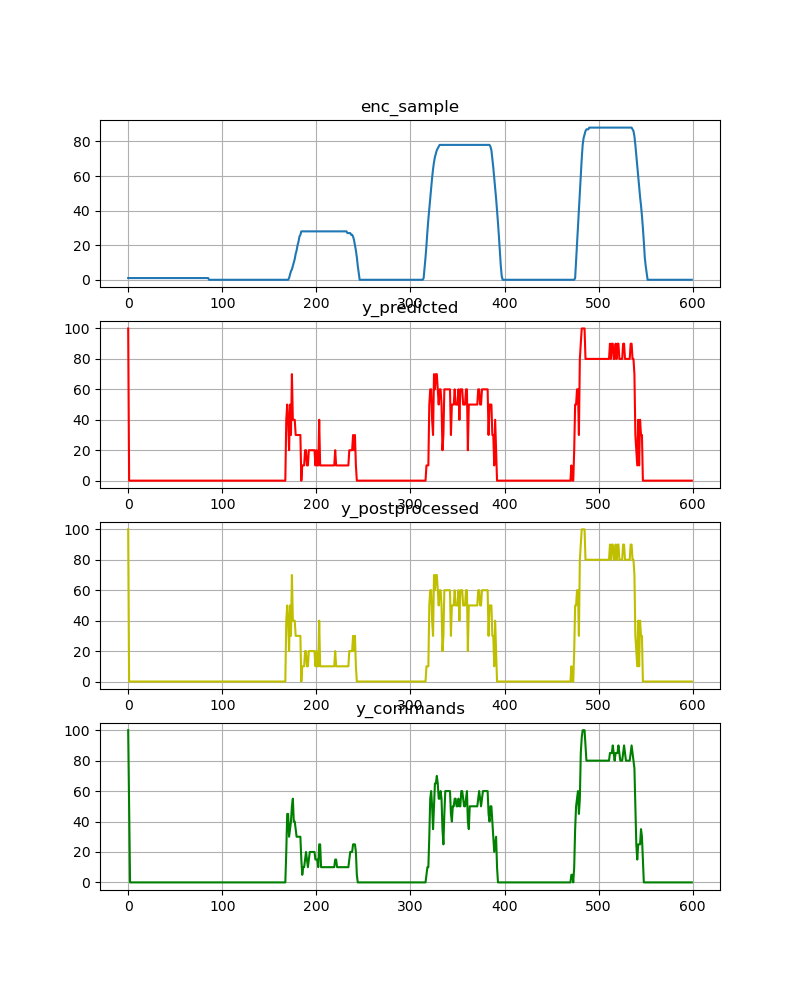

In [17]:
plt.clf()
plt.cla()
fig, ax = plt.subplots(4, 1, figsize=(8, 10))

ax[0].set_title('enc_sample')
ax[0].plot(y_dct['enc_sample'][:,3][:600])
ax[0].grid()
ax[1].set_title('y_predicted')
ax[1].plot(y_dct['y_predicted'][:,3][:600], c='r')
ax[1].grid()
ax[2].set_title('y_postprocessed')
ax[2].plot(y_dct['y_postprocessed'][:,3][:600], c='y')
ax[2].grid()
ax[3].set_title('y_commands')
ax[3].plot(y_dct['y_commands'][:,3][:600], c='g')
ax[3].grid()


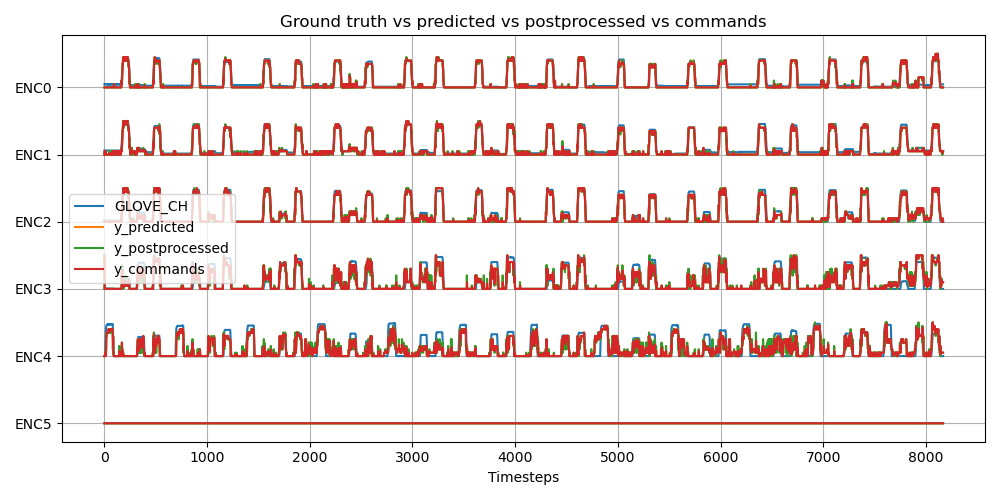

In [18]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()